# **Deep Learning Project**
**By: Mohanad Arafe (40042922) $\cdot$ Inés Gonzalez Pepe (40095696) $\cdot$ Rucha Shende (40205356)**

In [ ]:
!pip install -qqq medmnist
!pip install elasticdeform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 KB 2.4 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import medmnist
from medmnist import INFO, Evaluator
from numpy.random import RandomState
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Subset
import re
from torchvision import datasets, transforms

import elasticdeform
import elasticdeform.torch as etorch
import torchvision.models as models


# **Data vizualization**

Let's vizualiaze the data

  0%|          | 0/4170669 [00:00<?, ?it/s]

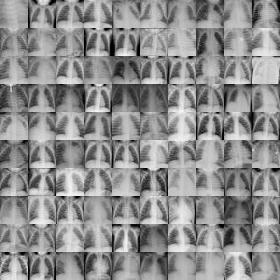

In [ ]:
data_flag = 'pneumoniamnist'
info = INFO[data_flag]
task = info['task']
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=True)
train_dataset.montage(length=10)

In [ ]:
import sys
sys.getsizeof(train_dataset)

48

# Challenge 1 Best Approach

## **Challenge 1 Data preprocessing**


In this section, we will implement data augmentation techniques in 3 papers:

1 - [Custom convolutional neural network with data augmentation to predict Pneumonia COVID19 ](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9487567)

2 - [What is the best data augmentation for 3D brain tumor segmentation?](https://www.diva-portal.org/smash/get/diva2:1588376/FULLTEXT01.pdf)

3 - [Classification of pneumonia from X-ray images using siamese convolutional network](https://core.ac.uk/download/pdf/295344322.pdf)

---



### Augmentation

In [ ]:
'''
Implementation of Augmentation Techniques
'''
class powerGammaEnhance(object):
    def __call__(self, img):
        c = random.uniform(0.8, 1.2)
        gamma = random.uniform(0.8, 1.2)
        gammaImg = c * (torch.sign(img) * torch.pow(torch.abs(img), gamma))
        return gammaImg

class elasticTransform(object):
    def __call__(self, img):
        deformedImage = elasticdeform.deform_random_grid(img.numpy(), axis=1, sigma=1)
        deformedImageTensor = torch.from_numpy(deformedImage)
        return deformedImageTensor

class autoContrast(object):
  def __call__(self, img):
    a_max = torch.max(img)
    a_min = torch.min(img)
    return (img - a_min) * (1 / (a_max - a_min))

In [ ]:
def get_transform(paper):
  '''
  Paper 1: Custom convolutional neural network with data augmentation to predict Pneumonia COVID19
  Paper 2: What is the best data augmentation for 3D brain tumor segmentation?
  Paper 3: Classification of pneumonia from X-ray images using siamese convolutional network
  '''
  if paper == "paper1":
    transform = transforms.Compose([
          transforms.ToTensor(),
          autoContrast(),
          transforms.RandomAffine(degrees=90, shear=[-45,45,-60,60]),
          transforms.Normalize((0.5), (0.5))
    ])
  if paper == "paper2":
    transform = transforms.Compose([
          transforms.ToTensor(),
          powerGammaEnhance(),
          elasticTransform(),
          transforms.Normalize((0.5), (0.5))
    ])
  if paper == "paper3":
    transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.RandomHorizontalFlip(),
          transforms.Normalize((0.5), (0.5))
    ])

  return transform

In [ ]:
from torchvision.transforms.transforms import Resize

# load the data
train_dataset = DataClass(split='train', transform=get_transform("paper2"), download=True)
val_dataset = DataClass(split='train', transform=get_transform("paper2"), download=True)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=32,
                                             shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=128,
                                             shuffle=False)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


### Vizualize transformation


[tensor([1]), tensor([0]), tensor([1])]


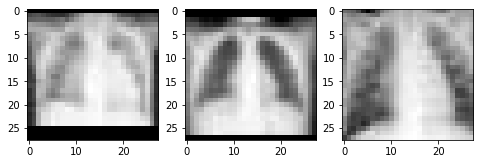

In [ ]:
plt.figure(figsize=(8,5))
for img, label in train_loader:
  images = [img[0][0], img[1][0], img[2][0]]
  labels = [label[0], label[1], label[2]]
  print(labels)
  for index, image in enumerate(images):
    plt.subplot(1, 3, index+1)
    plt.imshow(image, cmap='gray')
  break

In [ ]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target.float())
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, name="\nVal"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.binary_cross_entropy_with_logits(output, target.float(), size_average=False).item() # sum up batch loss
            pred = output >= 0.5
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=16)
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(num_features=32)
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3=nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.pool3=nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.bn4=nn.BatchNorm2d(num_features=64)
        self.pool4=nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout(0.15)
        self.relu = nn.ReLU()

        self.fc=nn.Linear(64*1*1, 1)

    def forward(self,img):
        output = self.conv1(img)
        output = self.bn1(self.relu(output))
        output = self.pool1(output)

        output = self.conv2(output)
        output = self.bn2(self.relu(output))
        output = self.pool2(output)

        output = self.conv3(output)
        output = self.bn3(self.relu(output))
        output = self.pool3(output)

        output = self.conv4(output)
        output = self.bn4(self.relu(output))
        output = self.pool4(output)

        output = self.drop(output)
        output=output.view(-1, 64*1*1)
        output=self.fc(output)
        return output

In [ ]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

n_classes = len(info['label'])
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
accs_val = []

for seed in  range(0, 25):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  train_top = 10//n_classes
  val_top = 1000//n_classes
  indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
  indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

  train_data = Subset(train_dataset, indx_train)
  val_data = Subset(val_dataset, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=32,
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                             batch_size=128,
                                             shuffle=False)

  model = ConvNet()
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

  for epoch in range(50):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
  accs_val.append(test(model, device, val_loader))

accs_val = np.array(accs_val)

print('Val acc over 5 instances on dataset: %s %.2f +- %.2f'%(data_flag, accs_val.mean(), accs_val.std()))

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 1.185957
Train Epoch: 5 [0/10 (0%)]	Loss: 0.331198
Train Epoch: 10 [0/10 (0%)]	Loss: 0.122414
Train Epoch: 15 [0/10 (0%)]	Loss: 0.047350
Train Epoch: 20 [0/10 (0%)]	Loss: 0.035110
Train Epoch: 25 [0/10 (0%)]	Loss: 0.087072
Train Epoch: 30 [0/10 (0%)]	Loss: 0.042606
Train Epoch: 35 [0/10 (0%)]	Loss: 0.004512
Train Epoch: 40 [0/10 (0%)]	Loss: 0.007817
Train Epoch: 45 [0/10 (0%)]	Loss: 0.006863


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Val set: Average loss: 0.4220, Accuracy: 856/1000 (85.60%)

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.767459
Train Epoch: 5 [0/10 (0%)]	Loss: 0.189082
Train Epoch: 10 [0/10 (0%)]	Loss: 0.117139
Train Epoch: 15 [0/10 (0%)]	Loss: 0.133799
Train Epoch: 20 [0/10 (0%)]	Loss: 0.013394
Train Epoch: 25 [0/10 (0%)]	Loss: 0.005709
Train Epoch: 30 [0/10 (0%)]	Loss: 0.011425
Train Epoch: 35 [0/10 (0%)]	Loss: 0.012136
Train Epoch: 40 [0/10 (0%)]	Loss: 0.009470
Train Epoch: 45 [0/10 (0%)]	Loss: 0.007508

Val set: Average loss: 0.4156, Accuracy: 842/1000 (84.20%)

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.609916
Train Epoch: 5 [0/10 (0%)]	Loss: 0.149414
Train Epoch: 10 [0/10 (0%)]	Loss: 0.215004
Train Epoch: 15 [0/10 (0%)]	Loss: 0.057474
Train Epoch: 20 [0/10 (0%)]	Loss: 0.013740
Train Epoch: 25 [0/10 (0%)]	Loss: 0.182964
Train Epoch: 30 [0/10 (0%)]	Loss: 0.098788
Train Epoch: 35 [0/10 (0%)]	Loss: 0.022188
Tr

# Challenge 2 Best Approach

In [ ]:
import time
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

# preprocessing
data_flag = 'pneumoniamnist'
download = True

info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
      transforms.Resize(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[.5], std=[.5]),
      transforms.Lambda(lambda x: x.repeat(3, 1, 1) )
      ])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='train', transform=data_transform, download=download)

accs_val = []

for seed in  range(0, 10):
  start_time = time.time()
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  train_top = 10//n_classes
  val_top = 1000//n_classes
  indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
  indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

  train_data = Subset(train_dataset, indx_train)
  val_data = Subset(val_dataset, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=32,
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                             batch_size=128,
                                             shuffle=False)
  model = models.vgg11(pretrained=True)
  model.classifier = nn.Sequential(
            nn.Linear(25088 , 1500),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(1500 , 1),
            nn.Sigmoid(),
        )

  model.to(device)
  optimizer = torch.optim.Adam(model.classifier.parameters(),lr=1e-3)

  for epoch in range(30):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
  print('Training time: %s'%(time.time()-start_time))
  start_time = time.time()
  accs_val.append(test(model, device, val_loader))
  print('Test time: %s'%(time.time()-start_time))

accs_val = np.array(accs_val)

print('Val acc over 5 instances on dataset: %s %.2f +- %.2f'%(data_flag, accs_val.mean(), accs_val.std()))

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Num Samples For Training 10 Num Samples For Val 1000


Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Train Epoch: 0 [0/10 (0%)]	Loss: 0.711793
Train Epoch: 5 [0/10 (0%)]	Loss: 0.503564
Train Epoch: 10 [0/10 (0%)]	Loss: 0.503205
Train Epoch: 15 [0/10 (0%)]	Loss: 0.503204
Train Epoch: 20 [0/10 (0%)]	Loss: 0.503204
Train Epoch: 25 [0/10 (0%)]	Loss: 0.503204
Training time: 19.970415830612183


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Val set: Average loss: 0.5484, Accuracy: 896/1000 (89.60%)

Test time: 14.20354700088501
Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.721907
Train Epoch: 5 [0/10 (0%)]	Loss: 0.503302
Train Epoch: 10 [0/10 (0%)]	Loss: 0.503207
Train Epoch: 15 [0/10 (0%)]	Loss: 0.503205
Train Epoch: 20 [0/10 (0%)]	Loss: 0.503204
Train Epoch: 25 [0/10 (0%)]	Loss: 0.503205
Training time: 15.886918783187866

Val set: Average loss: 0.5532, Accuracy: 887/1000 (88.70%)

Test time: 14.203418016433716
Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.727482
Train Epoch: 5 [0/10 (0%)]	Loss: 0.503589
Train Epoch: 10 [0/10 (0%)]	Loss: 0.503205
Train Epoch: 15 [0/10 (0%)]	Loss: 0.503204
Train Epoch: 20 [0/10 (0%)]	Loss: 0.503204
Train Epoch: 25 [0/10 (0%)]	Loss: 0.503204
Training time: 15.90390419960022

Val set: Average loss: 0.5539, Accuracy: 897/1000 (89.70%)

Test time: 14.23663592338562
Num Samples For Training 10 Num Samples For 

## **OTHER APPROACHES BESIDES THE MOST SUCCESSFUL MODELS DO NOT HAVE ANY OUTPUT AND MUST BE RUN OR THE REPORT MUST BE CONSULTED**

# Challenge 1 Other Approaches

## **Challenge 1 Siamese Network with BCELoss**

### Custom DataLoader

In [ ]:
from torch.utils.data import DataLoader, Dataset

class SiameseNetworkDataset(Dataset):
    def __init__(self,dataset,transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.dataset)

        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.dataset)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.dataset)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        if self.transform is not None:
            img0 = self.transform(img0_tuple[0])
            img1 = self.transform(img1_tuple[0])

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.dataset)

### Load data

In [ ]:
siamese_dataset = SiameseNetworkDataset(train_dataset, transform=get_transform("paper3"))

train_loader = DataLoader(siamese_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(siamese_dataset, batch_size=32,shuffle=True,drop_last=True)

### Model

In [ ]:
class Siamese(nn.Module):
    def __init__(self):
        super(Siamese, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(p=0.5)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 5)
        self.fcOut = nn.Linear(5, 10)
        self.sigmoid = nn.Sigmoid()

    def linear_layers(self, x):
      output = nn.Sequential(
          nn.Linear(int(x.shape[0]), int(x.shape[0]/2)),
          nn.Dropout(0.5),
          nn.Linear(int(x.shape[0]/2), int(x.shape[0]/2)),
          nn.Dropout(0.5),
          nn.Linear(int(x.shape[0]/2), int(x.shape[0]))
      )
      output = output.to('cuda')
      return output(x)

    def convs(self, x):
        x = self.relu(self.bn1(self.conv1(x))) #32,26,26
        x = self.relu(self.conv2(x)) #64,24,24
        x = self.pool(self.drop(x)) #64,12,12

        x = self.relu(self.conv3(x)) #64,10,10
        x = self.pool(self.drop(x)) #64,5,5
        x = self.relu(self.bn2(self.conv4(x))) #128,3,3

        x = self.relu(self.conv5(x)) #128,1,1

        return x

    def forward(self, x1, x2):
        cos = nn.CosineSimilarity()
        x1 = self.convs(x1)
        x2 = self.convs(x2)
        similarity = F.cosine_similarity(x1, x2).view(x1.shape[0])

        output = self.linear_layers(similarity)

        output = self.sigmoid(output)
        return output

### Training & Testing

In [ ]:
def train(model, device, train_loader, optimizer, criterion, epoch, display=True):
    model.train()
    for batch_idx, (image1, image2, labels) in enumerate(train_loader):
        image1, image2, labels = image1.to(device), image2.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(image1, image2)
        labels = labels.float()
        loss = criterion(output, labels.view(output.shape))
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(image1), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, name="\nVal"):
    model.eval()
    test_loss = 0
    correct = 0
    test_predictions = []
    with torch.no_grad():
        for image1, image2, labels in test_loader:
            image1, image2, labels = image1.to(device), image2.to(device), labels.to(device)
            output = model(image1, image2)
            test_loss += F.binary_cross_entropy_with_logits(output, labels.view(output.shape), size_average=False).item() # sum up batch loss
            for index, prob in enumerate(output):
              if prob <= 0.5 and labels[index] == 0:
                correct +=1
              if prob > 0.5 and labels[index] == 1:
                correct +=1

    test_loss /= len(test_loader.dataset)
    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

### Run

In [ ]:
%%time
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

n_classes = len(info['label'])
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
accs_val = []

for seed in  range(0, 25):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  train_top = 10//n_classes
  val_top = 1000//n_classes
  indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
  indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

  train_data = Subset(siamese_dataset, indx_train)
  val_data = Subset(siamese_dataset, indx_val)

  # print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=32,
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                          batch_size=32,
                                          shuffle=False)

  model = Siamese()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=1e-6)
  criterion = nn.BCELoss()

  for epoch in range(50):
    train(model, device, train_loader, optimizer, criterion, epoch, display=epoch%5==0)
  accs_val.append(test(model, device, val_loader))

accs_val = np.array(accs_val)

print('Val acc over 5 instances on dataset: %s %.2f +- %.2f'%(data_flag, accs_val.mean(), accs_val.std()))

Train Epoch: 0 [0/10 (0%)]	Loss: 0.642115
Train Epoch: 5 [0/10 (0%)]	Loss: 0.733932
Train Epoch: 10 [0/10 (0%)]	Loss: 0.612360
Train Epoch: 15 [0/10 (0%)]	Loss: 0.664338
Train Epoch: 20 [0/10 (0%)]	Loss: 0.755700
Train Epoch: 25 [0/10 (0%)]	Loss: 0.707801
Train Epoch: 30 [0/10 (0%)]	Loss: 0.808173
Train Epoch: 35 [0/10 (0%)]	Loss: 0.852389
Train Epoch: 40 [0/10 (0%)]	Loss: 0.693990
Train Epoch: 45 [0/10 (0%)]	Loss: 0.770459


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Val set: Average loss: 0.7309, Accuracy: 520/1000 (52.00%)

Train Epoch: 0 [0/10 (0%)]	Loss: 0.681652
Train Epoch: 5 [0/10 (0%)]	Loss: 0.707593
Train Epoch: 10 [0/10 (0%)]	Loss: 0.647253
Train Epoch: 15 [0/10 (0%)]	Loss: 0.766632
Train Epoch: 20 [0/10 (0%)]	Loss: 0.713209
Train Epoch: 25 [0/10 (0%)]	Loss: 0.677674
Train Epoch: 30 [0/10 (0%)]	Loss: 0.752512
Train Epoch: 35 [0/10 (0%)]	Loss: 0.612978
Train Epoch: 40 [0/10 (0%)]	Loss: 0.713785
Train Epoch: 45 [0/10 (0%)]	Loss: 0.687019

Val set: Average loss: 0.7343, Accuracy: 481/1000 (48.10%)

Train Epoch: 0 [0/10 (0%)]	Loss: 0.668727
Train Epoch: 5 [0/10 (0%)]	Loss: 0.739112
Train Epoch: 10 [0/10 (0%)]	Loss: 0.809220
Train Epoch: 15 [0/10 (0%)]	Loss: 0.716083
Train Epoch: 20 [0/10 (0%)]	Loss: 0.699347
Train Epoch: 25 [0/10 (0%)]	Loss: 0.725095
Train Epoch: 30 [0/10 (0%)]	Loss: 0.660420
Train Epoch: 35 [0/10 (0%)]	Loss: 0.697072
Train Epoch: 40 [0/10 (0%)]	Loss: 0.693738
Train Epoch: 45 [0/10 (0%)]	Loss: 0.759939

Val set: Average loss

## **Challenge 1 CNN + Attention integration**


---

Inspired by this paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9311985

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


### CNN + Attention Model

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, num_heads=2):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()

        self.layers+=[nn.Conv2d(1, 16,  kernel_size=3) ,
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 16,  kernel_size=3, stride=5),  #removed stride=2
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 32,  kernel_size=3),
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(32, 32,  kernel_size=3, stride=2),
                      nn.ReLU(inplace=True)]

        self.attention = torch.nn.MultiheadAttention(26**2, num_heads=num_heads)
        self.positional_encoding = nn.Parameter(torch.rand(28, 28))
        self.bn1 = nn.BatchNorm2d(16)



        self.fc = nn.Linear(32, 1)


    def forward(self, x):
      batch_size = x.shape[0]
      dims = 0

      x += self.positional_encoding

      for i in range(len(self.layers)):
        x = self.layers[i](x)

        if i == 0:
          x = self.bn1(x)
          dims = x.shape[-1]
          x = x.view(batch_size, 16, -1)
          x, _ = self.attention(x, x, x)

          x = x.view(batch_size, -1, dims,dims)


      x = x.view(-1, 32)
      x = self.fc(x)
      return x

### ResNet Model

In [ ]:
class ResBlock_with_Attention(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.attention = torch.nn.MultiheadAttention(out_channels, num_heads=2)


    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        batch_size = input.shape[0]
        out = input.shape[-1]
        input = input.reshape(batch_size, -1, out**2).permute(0,2,1)
        input, _ = self.attention(input, input, input)
        input = input.permute(0,2,1).reshape(batch_size, -1, out, out)
        input = input + shortcut
        return nn.ReLU()(input)

class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, outputs=1000):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=True)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(512, outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input)
        input = input.reshape(-1,512)
        input = self.fc(input)

        return input

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.attention = torch.nn.MultiheadAttention(out_channels, num_heads=2)


    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

class ResNet18_with_Attention(nn.Module):
    def __init__(self, in_channels, resblock, outputs=1000):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=True)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(512, outputs)
        self.attention = torch.nn.MultiheadAttention(64, num_heads=2)

    def forward(self, input):
        batch_size = input.shape[0]

        input = input.to(device)
        input = self.layer0(input)
        input = self.layer1(input)
        # out = input.shape[-1]
        # input = input.reshape(batch_size, -1, 64)
        # input, _ = self.attention(input, input, input)
        # input = input.permute(0,2,1).reshape(batch_size, -1, out, out)
        input = self.layer2(input)
        input = self.layer3(input)
        # batch_size = input.shape[0]
        # out = input.shape[-1]
        # input = input.reshape(batch_size, -1, 64)
        # input, _ = self.attention(input, input, input)
        # input = input.permute(0,2,1).reshape(batch_size, -1, out, out)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input)
        # batch_size = input.shape[0]
        # out = input.shape[-1]
        # input = input.reshape(batch_size,-1)
        # input = input.reshape(1, -1, 64)
        # input, _ = self.attention(input, input, input)
        input = self.fc(input)
        return input.reshape(-1,1)

### Ensemble Model

In [ ]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB, nb_classes=10):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        # Remove last linear layer
        self.modelA.fc = nn.Identity()
        self.modelB.fc = nn.Identity()

        # Create new classifier
        self.classifier = nn.Linear(32+512, nb_classes)

    def forward(self, x):
        x1 = self.modelA(x.clone())  # clone to make sure x is not changed by inplace methods
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x)
        x2 = x2.view(x2.size(0), -1)
        x = torch.cat((x1, x2), dim=1)

        # print(x1.shape, x2.shape)

        x = self.classifier(F.relu(x))
        return x

### Training

In [ ]:
def run_samples(model):
  torch.manual_seed(0)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  random.seed(0)
  np.random.seed(0)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  # preprocessing
  data_flag = 'pneumoniamnist'

  download = True

  info = INFO[data_flag]
  n_classes = len(info['label'])
  DataClass = getattr(medmnist, info['python_class'])

  # data augmentation
  data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5]),
        ])

  # load the data
  train_dataset = DataClass(split='train', transform=data_transform, download=True)
  val_dataset = DataClass(split='train', transform=data_transform, download=True)

  accs_val = []

  for seed in  range(0, 5):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    train_top = 10//n_classes
    val_top = 1000//n_classes
    indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
    indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

    train_data = Subset(train_dataset, indx_train)
    val_data = Subset(val_dataset, indx_val)

    print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

    train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size=32,
                                              shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                              batch_size=128,
                                              shuffle=False)

    # model = Net()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

    for epoch in range(50):
      train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    accs_val.append(test(model, device, val_loader))

  accs_val = np.array(accs_val)

  print('Val acc over 5 instances on dataset: %s %.2f +- %.2f'%(data_flag, accs_val.mean(), accs_val.std()))

### Training CNN + Attention Model

In [ ]:
run_samples(Net()) #in forward statement, modify if statement to determine when attention is integrated -- default is after layer 0

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.693466
Train Epoch: 5 [0/10 (0%)]	Loss: 0.505438
Train Epoch: 10 [0/10 (0%)]	Loss: 0.022457
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000003
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000000
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000000
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000000
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000000
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000000
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000000


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Val set: Average loss: 2.4340, Accuracy: 883/1000 (88.30%)

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 1.753306
Train Epoch: 5 [0/10 (0%)]	Loss: 0.985940
Train Epoch: 10 [0/10 (0%)]	Loss: 0.402473
Train Epoch: 15 [0/10 (0%)]	Loss: 0.138508
Train Epoch: 20 [0/10 (0%)]	Loss: 0.032738
Train Epoch: 25 [0/10 (0%)]	Loss: 0.007742
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000390
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000496
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000501
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000423

Val set: Average loss: 1.5444, Accuracy: 837/1000 (83.70%)

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 1.769435
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000165
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000104
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000096
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000087
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000075
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000065
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000056
Tr

### Training ResNet Model

In [ ]:
run_samples(ResNet18(1, ResBlock_with_Attention, 1)) #change out ResBlock_with_Attention for ResBlock or ResNet for ResNet18_with_Attention to integrate attention in different areas

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.691042
Train Epoch: 5 [0/10 (0%)]	Loss: 0.009453
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000143
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000033
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000014
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000007
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000004
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000003
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000002
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000001


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Val set: Average loss: 2.0434, Accuracy: 501/1000 (50.10%)

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 1.315539
Train Epoch: 5 [0/10 (0%)]	Loss: 0.125735
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000577
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000872
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000507
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000133
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000059
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000021
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000008
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000003

Val set: Average loss: 2.1380, Accuracy: 748/1000 (74.80%)

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 4.865797
Train Epoch: 5 [0/10 (0%)]	Loss: 0.178551
Train Epoch: 10 [0/10 (0%)]	Loss: 0.011783
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000789
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000293
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000124
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000041
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000017
Tr

### Training Ensemble Model

In [ ]:
modelA = ResNet18(1, ResBlock, 1)
modelA.to(device)
modelB = Net()
modelB.to(device)
run_samples(MyEnsemble(modelA, modelB,1))

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.762539
Train Epoch: 5 [0/10 (0%)]	Loss: 0.027926
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000284
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000021
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000006
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000003
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000002
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000002
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000001
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000001


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Val set: Average loss: 1.4078, Accuracy: 481/1000 (48.10%)

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 3.789660
Train Epoch: 5 [0/10 (0%)]	Loss: 0.013643
Train Epoch: 10 [0/10 (0%)]	Loss: 0.001353
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000098
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000011
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000003
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000001
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000000
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000000
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000000

Val set: Average loss: 2.2334, Accuracy: 579/1000 (57.90%)

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 3.689221
Train Epoch: 5 [0/10 (0%)]	Loss: 0.091481
Train Epoch: 10 [0/10 (0%)]	Loss: 0.013815
Train Epoch: 15 [0/10 (0%)]	Loss: 0.002584
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000646
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000209
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000089
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000057
Tr

# Challenge 2 Other Approaches

## **Challenge 2 ResNet50 module**


---



###Approach inspired from : [Predicting Pneumonia and Region Detection from X-Ray Images using Deep Neural Network](https://arxiv.org/ftp/arxiv/papers/2101/2101.07717.pdf)

     |████████████████████████████████| 87 kB 3.1 MB/s 


  0%|          | 0/4170669 [00:00<?, ?it/s]

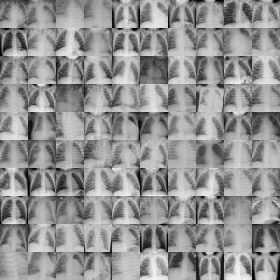

In [ ]:
!pip install -qqq medmnist

from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision

import medmnist
from medmnist import INFO, Evaluator
from numpy.random import RandomState
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Subset
import re
from torchvision import datasets, transforms

data_flag = 'pneumoniamnist'
info = INFO[data_flag]
task = info['task']
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=True)
train_dataset.montage(length=10)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


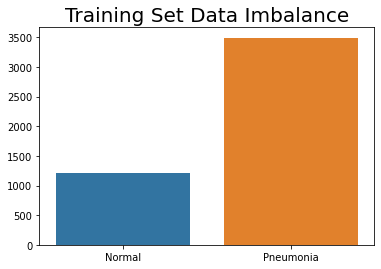

In [ ]:
# number of images for each class
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import seaborn as sns

normal = 0
pneumonia = 0
for batch_idx, (data, target) in enumerate(train_dataset):
    if target == 0:
        normal+=1

    elif target == 1:
        pneumonia+=1

classes = pd.DataFrame.from_dict(
    {'Normal': [normal],
     'Pneumonia': [pneumonia]})

sns.barplot(data=classes).set_title('Training Set Data Imbalance', fontsize=20)
plt.show()



In [ ]:
class FocalLoss(nn.Module):
    "Non weighted version of Focal Loss"
    def __init__(self, alpha=.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha]).to(device)
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        at = self.alpha.gather(0, targets.data.view(-1))
        pt = torch.exp(-BCE_loss)
        F_loss = at*(1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

focal_loss = FocalLoss()

In [ ]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        #print(data.shape)
        #print(target.shape)
        optimizer.zero_grad()
        output = model(data)

        loss = focal_loss(output, target)
        loss.backward()

        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, name="\nVal"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #target = target.float().resize_(len(target), 2)
            output = model(data)
            test_loss += focal_loss(output, target)
            pred = output >= 0.5
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [ ]:
import time

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

# preprocessing
data_flag = 'pneumoniamnist'
download = True

info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
      #Image size of 224,224,3 was used as input for base model
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[.5], std=[.5]),
      transforms.Lambda(lambda x: x.repeat(3, 1, 1) )
      ])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='train', transform=data_transform, download=download)




accs_val = []
times = []

for seed in  range(0,50):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  train_top = 10//n_classes
  val_top = 1000//n_classes
  indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
  indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

  train_data = Subset(train_dataset, indx_train)
  val_data = Subset(val_dataset, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=16,
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                             batch_size=128,
                                             shuffle=False)
  model = models.alexnet(pretrained=True)
  model.classifier = nn.Linear(256 * 6 * 6, 1)

  model.to(device)
  #optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
  #optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2, alpha=0.99, eps=1e-3, weight_decay=0, momentum=0.9, centered=False)
  optimizer = torch.optim.Adam(model.classifier.parameters(),lr=1e-3)

  begin = time.clock()
  for epoch in range(50):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)

  end = time.clock()
  print('Time taken - ',(end-begin))
  times.append(end-begin)

  accs_val.append(test(model, device, val_loader))

accs_val = np.array(accs_val)
times = np.array(times)

print('Val acc over 5 instances on dataset: %s %.2f +- %.2f'%(data_flag, accs_val.mean(), accs_val.std()))
print('Average time in seconds taken to run the model:' ,times.mean())



Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Num Samples For Training 10 Num Samples For Val 1000


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Train Epoch: 0 [0/10 (0%)]	Loss: 0.113067
Train Epoch: 5 [0/10 (0%)]	Loss: 0.013844
Train Epoch: 10 [0/10 (0%)]	Loss: 0.001844
Train Epoch: 15 [0/10 (0%)]	Loss: 0.001042
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000387
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000153
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000081
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000056
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000045
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000040
Time taken -  2.022879999999999


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



Val set: Average loss: 0.0007, Accuracy: 879/1000 (87.90%)

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.083161
Train Epoch: 5 [0/10 (0%)]	Loss: 0.026873
Train Epoch: 10 [0/10 (0%)]	Loss: 0.001368
Train Epoch: 15 [0/10 (0%)]	Loss: 0.001170
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000813
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000437
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000231
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000135
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000089
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000065
Time taken -  1.7840159999999976

Val set: Average loss: 0.0011, Accuracy: 802/1000 (80.20%)

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.089357
Train Epoch: 5 [0/10 (0%)]	Loss: 0.004266
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000591
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000176
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000072
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000039
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000026
Train Epoch:

## **Challenge 2 Transfer Learning**

In [ ]:
#same ensemble model as before
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB, modelC=None, nb_classes=10):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        # Remove last linear layer
        self.modelA.fc = nn.Identity()
        self.modelB.fc = nn.Identity()

        # Create new classifier
        self.classifier = nn.Linear(32+512, nb_classes)

    def forward(self, x):
        x1 = self.modelA(x.clone())  # clone to make sure x is not changed by inplace methods
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x.clone())
        x2 = x2.view(x2.size(0), -1)
        x = torch.cat((x1, x2), dim=1)
        x = self.classifier(F.relu(x))
        return x

#CNN used in data augmentation that achieved best results
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.pool1=nn.MaxPool2d(kernel_size=2)

        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(num_features=20)
        self.pool2=nn.MaxPool2d(kernel_size=2)

        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.pool3=nn.MaxPool2d(kernel_size=2)

        self.conv4=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.bn4=nn.BatchNorm2d(num_features=64)
        self.pool4=nn.MaxPool2d(kernel_size=2)
        self.drop = nn.Dropout(0.5)
        self.relu = nn.ReLU()

        self.fc=nn.Linear(64*1*1, 1)
        self.fc2 = nn.Linear(96,1)

    def forward(self,img):
        batch_size = img.shape[0]
        img = img.reshape(batch_size,1,256,-1)
        output = self.conv1(img)
        output = self.relu(self.bn1(output))
        output = self.pool1(output)

        output = self.conv2(output)
        output = self.relu(self.bn2(output))
        output = self.pool2(output)

        output = self.conv3(output)
        output = self.relu(self.bn3(output))
        output = self.pool3(output)

        output = self.conv4(output)
        output = self.relu(self.bn4(output))
        output = self.pool4(output)

        output = self.drop(output)
        output=output.view(-1, 64*1*1)
        output=self.fc(output)
        output = output.reshape(batch_size, -1)
        print(output.shape)
        output = self.fc2(output.squeeze())
        return output.reshape(-1,1)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = nn.init.xavier_normal_(torch.empty(self.num_layers, x.size(0), self.hidden_size)).to(device)

        # Forward propagate LSTM
        batch_size = x.shape[0]
        x = x.reshape(batch_size, 256, -1)

        out , _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

class LSTM_VGG(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_VGG, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, model):
        # Set initial hidden and cell states
        hidden = model(x).to(device)
        hidden = hidden.reshape(1,10,-1)
        hidden2 = hidden.clone()
        for i in range(self.num_layers-1):
          hidden=torch.concat((hidden, hidden2))

        x = x.reshape(x.shape[0], 256, -1)
        print(x.shape, hidden.shape)

        out , _ = self.lstm(x, (hidden, hidden))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

class RNN_VGG(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_VGG, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, model):
        # Set initial hidden and cell states
        hidden = model(x).to(device)
        hidden = hidden.reshape(1,10,-1)
        hidden2 = hidden.clone()
        for i in range(self.num_layers-1):
          hidden=torch.concat((hidden, hidden2))

        x = x.reshape(x.shape[0], 256, -1)

        out , _ = self.rnn(x, hidden)  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = nn.init.xavier_normal_(torch.empty(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c0 = nn.init.xavier_normal_(torch.empty(self.num_layers, x.size(0), self.hidden_size)).to(device)

        # Forward propagate LSTM
        batch_size = x.shape[0]
        x = x.reshape(batch_size, 256, -1).to(device)
        out , _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
feature_extractor = True #are you running a model that uses a pretrained model as a feature extractor

In [ ]:
import time
def train_vgg(model, device, train_loader, optimizer, epoch, vgg=None, display=True):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, vgg)
        pred = output >= 0.5
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss = F.binary_cross_entropy_with_logits(output, target.float())
        loss.backward()
        optimizer.step()
    # print(correct, len(train_loader))
    intermediate_train_results_1['RNN']['accuracy'].append(10.*correct/len(train_loader))
    intermediate_train_results_1['RNN']['loss'].append(loss.item())

    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          10.* correct / len(train_loader), loss.item()))

def test_vgg(model, device, test_loader, vgg=None name="\nVal"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, vgg)
            test_loss += F.binary_cross_entropy_with_logits(output, target.float(), size_average=False).item() # sum up batch loss
            pred = output >= 0.5
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(name, test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    intermediate_test_results_1['RNN']['accuracy'].append(100. * correct / len(test_loader.dataset))
    intermediate_test_results_1['RNN']['loss'].append(test_loss)
    return 100. * correct / len(test_loader.dataset)


torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

# preprocessing
data_flag = 'pneumoniamnist'
download = True

info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
      transforms.Resize(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[.5], std=[.5]),
      transforms.Lambda(lambda x: x.repeat(3, 1, 1) )
      ])


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='train', transform=data_transform, download=download)

accs_val = []

for seed in  range(0, 10):
  start_time = time.time()
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  train_top = 10//n_classes
  val_top = 1000//n_classes
  indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
  indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

  train_data = Subset(train_dataset, indx_train)
  val_data = Subset(val_dataset, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=32,
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                             batch_size=10,
                                             shuffle=False)
  # model = models.alexnet(pretrained=True)
  # model = models.vgg16(pretrained=True)
  # model = MyEnsemble(models.vgg11(pretrained=True), models.vgg16(pretrained=True))
  # model.classifier = nn.Linear(256 * 6 * 6, 1) #for alexnet
  # model.classifier = nn.Linear(2000,1) #for ensemble #vgg16 25088
  # model.classifier = nn.Sequential(
  #           nn.Linear(25088 , 1500),
  #           nn.ReLU(),
  #           nn.Dropout(0.7),
  #           nn.Linear(1500 , 1),
  #           nn.Sigmoid(),
  #       )
  model = LSTM(588, 50, 1, 1).to(device) #RNN too
  # model = LSTM_VGG(588, 1000,3,1).to(device) #RNN_VGG too
  # model.classifier = ConvNet()

  model.to(device)
  if feature_extractor:
      vgg = models.vgg11(pretrained=True).eval().to(device)
      optimizer = torch.optim.Adam(model.parameters(),lr=3e-3)
  else: optimizer = torch.optim.Adam(model.classifier.parameters(),lr=3e-3)

  for epoch in range(50):
    if feature_extractor: train_vgg(model, device, train_loader, optimizer, epoch, vgg, display=epoch%5==0)
    else: train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
  training_time_1['RNN'].append(time.time()-start_time)
  start_time = time.time()
  if feature_extractor: accs_val.append(test(model, device, val_loader, vgg))
  else: accs_val.append(test(model, device, val_loader))
  test_time_1['RNN'].append(time.time()-start_time)

accs_val = np.array(accs_val)

print('Val acc over 5 instances on dataset: %s %.2f +- %.2f'%(data_flag, accs_val.mean(), accs_val.std()))



## **Challenge 2 Siamese Network with Triplet Loss**

In [ ]:
!pip install -qqq medmnist

     |████████████████████████████████| 87 kB 2.8 MB/s 


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader

from tqdm import tqdm
import torch.optim as optim
import torch.utils.data as data

import medmnist
from medmnist import INFO, Evaluator
from numpy.random import RandomState
from torch.utils.data import Subset
import re
from torchvision import datasets, transforms

In [ ]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)
import time
import pickle

# preprocessing
data_flag_b = 'breastmnist'
data_flag_p = 'pneumoniamnist'
download = True

info_b = INFO[data_flag_b]
n_classes = len(info_b['label'])
DataClass_B = getattr(medmnist, info_b['python_class'])

info_p = INFO[data_flag_p]
n_classes = len(info_p['label'])
DataClass_P = getattr(medmnist, info_p['python_class'])


def tmp_func(x):
    return x.repeat(3, 1, 1)

data_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[.5], std=[.5]),
         transforms.Lambda(tmp_func)
      ])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load the data
train_dataset_breastmnist = DataClass_B(split='train', transform=data_transform, download=download)
val_dataset_breastmnist = DataClass_B(split='test', transform=data_transform, download=download)

train_dataset_pneumoniamnist = DataClass_P(split='train', transform=data_transform, download=download)
val_dataset_pneumoniamnist = DataClass_P(split='test', transform=data_transform, download=download)

train_loader_breastmnist = torch.utils.data.DataLoader(train_dataset_breastmnist,
                                     batch_size=16,
                                     shuffle=True,
                                    num_workers=1,
                                     drop_last=True)

val_loader_breastmnist = torch.utils.data.DataLoader(val_dataset_breastmnist,
                                     batch_size=16,
                                     shuffle=False,
                                      num_workers=1,
                                     drop_last=True)


train_loader_pneumoniamnist = torch.utils.data.DataLoader(train_dataset_pneumoniamnist,
                                     batch_size=16,
                                     shuffle=True,
                                    num_workers=1,
                                     drop_last=True)

val_loader_pneumoniamnist = torch.utils.data.DataLoader(val_dataset_pneumoniamnist,
                                     batch_size=16,
                                     shuffle=False,
                                      num_workers=1,
                                     drop_last=True)


  0%|          | 0/559580 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz


  0%|          | 0/4170669 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_triplet_loss = models.alexnet(pretrained=True)
model_triplet_loss.classifier = nn.Linear(256 * 6 * 6, 1)


optimizer = torch.optim.Adam(model_triplet_loss.classifier.parameters(),lr=1e-5)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
def generateTriplets(p_labels, b_labels):
    label_set = range(0,2)
    label_to_indices = {label: np.where(b_labels.cpu().numpy() == label)[0]
                                for label in label_set}

    #print(label_to_indices)
    idx_pos = []
    idx_neg = []
    for lab in p_labels:
        positive_index = np.random.choice(label_to_indices[lab.item()])
        #print(positive_index)
        negative_label = np.random.choice(list(set(label_set) - set([lab.item()])))
        #print(negative_label)
        #print(label_to_indices[negative_label])
        negative_index = np.random.choice(label_to_indices[negative_label])

        idx_pos.append(positive_index)
        idx_neg.append(negative_index)

    return idx_pos, idx_neg


In [ ]:
tripletLoss = nn.TripletMarginLoss(margin=0.5)
weight = 1
optimizer = torch.optim.Adam(model_triplet_loss.classifier.parameters(),lr=1e-5)

In [ ]:
losses = []

epoch = 0
while epoch < 20:

    p_iterator = iter(train_loader_pneumoniamnist)
    for idx, (images_b, labels_b) in enumerate(train_loader_breastmnist):
        try:
            images_p, labels_p = next(p_iterator)
            #print(images_p.shape)
            #print(labels_p.shape)
        except StopIteration:
            p_iterator = iter(train_loader_pneumoniamnist)
            images_p, labels_p = next(p_iterator)

    # pneumoniamnist loss
    idx_pos, idx_neg = generateTriplets(labels_p, labels_b)
    #print(images_p.shape)
    p_anchors = model_triplet_loss(images_p)

    b_negative = model_triplet_loss( images_b[idx_neg] )
    b_positive = model_triplet_loss( images_b[idx_pos] )

    l_1 = tripletLoss(p_anchors, b_positive, b_negative)


    # breastmnist loss
    idx_pos, idx_neg = generateTriplets(labels_b, labels_p)

    b_anchors = model_triplet_loss ( images_b )
    p_negative = model_triplet_loss( images_p[idx_neg] )
    p_positive = model_triplet_loss( images_p[idx_pos] )

    l_2 = tripletLoss(b_anchors, p_positive, p_negative)

    # Backprop
    loss = l_1 + l_2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print(loss)
    losses.append(loss.item())
    print(f"Epoch [{epoch}/20] | Current loss: {loss.item()}")

    epoch += 1
    if epoch > 20:
        break




Epoch [0/20] | Current loss: 1.178408145904541
Epoch [1/20] | Current loss: 1.099766492843628
Epoch [2/20] | Current loss: 1.1901352405548096
Epoch [3/20] | Current loss: 1.0315947532653809
Epoch [4/20] | Current loss: 0.9022835493087769
Epoch [5/20] | Current loss: 1.0505719184875488
Epoch [6/20] | Current loss: 1.156221628189087
Epoch [7/20] | Current loss: 1.0014407634735107
Epoch [8/20] | Current loss: 1.0602729320526123
Epoch [9/20] | Current loss: 1.0634938478469849
Epoch [10/20] | Current loss: 0.9998732805252075
Epoch [11/20] | Current loss: 0.9856717586517334
Epoch [12/20] | Current loss: 1.202401876449585
Epoch [13/20] | Current loss: 1.020613431930542
Epoch [14/20] | Current loss: 0.9684581756591797
Epoch [15/20] | Current loss: 0.9406706094741821
Epoch [16/20] | Current loss: 0.8886241912841797
Epoch [17/20] | Current loss: 1.0449620485305786
Epoch [18/20] | Current loss: 1.0880954265594482
Epoch [19/20] | Current loss: 1.1109845638275146


In [ ]:

def test(model, device, test_loader, name="\nVal"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      p_iterator = iter(test_loader)
      for idx, (images_b, labels_b) in enumerate(test_loader):
        try:
          images_p, labels_p = next(p_iterator)
          #print(images_p.shape)
          #print(labels_p.shape)
        except StopIteration:
          p_iterator = iter(test_loader)
          images_p, labels_p = next(p_iterator)


        # pneumoniamnist loss
        idx_pos, idx_neg = generateTriplets(labels_p, labels_b)
        p_anchors = model_triplet_loss(images_p)

        b_negative = model_triplet_loss( images_b[idx_neg] )
        b_positive = model_triplet_loss( images_b[idx_pos] )

        l_1 = tripletLoss(p_anchors, b_positive, b_negative)


        # breastmnist loss
        idx_pos, idx_neg = generateTriplets(labels_b, labels_p)

        b_anchors = model_triplet_loss ( images_b )
        p_negative = model_triplet_loss( images_p[idx_neg] )
        p_positive = model_triplet_loss( images_p[idx_pos] )

        l_2 = tripletLoss(b_anchors, p_positive, p_negative)

        # Backprop
        loss = l_1 + l_2

        losses.append(loss.item())
        test_loss +=loss
        output = p_positive.flatten().cpu().detach().numpy()
        for index, ele in enumerate(output):
          #if pneumonia is detected then the output value must be negative as negative label is assigned
          if ele < 0:
            correct += 1

    test_loss /= len(test_loader.dataset)
    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

accs_val = []
accs_val.append(test(model_triplet_loss, device, val_loader_pneumoniamnist))


Val set: Average loss: 0.0586, Accuracy: 42/624 (6.73%)

